# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 6.731966 (||params||=3.911954, ||grad||=9.232829, ||E[dr/dw]||=7.418349)
INFO:root:Occupancy measure error@iter  100: 0.111552 (||params||=5.049271, ||grad||=0.141597, ||E[dr/dw]||=7.038727)
INFO:root:Occupancy measure error@iter  200: 0.031425 (||params||=4.389548, ||grad||=0.042723, ||E[dr/dw]||=6.964626)
INFO:root:Occupancy measure error@iter  300: 0.006500 (||params||=4.293205, ||grad||=0.009123, ||E[dr/dw]||=6.940410)
INFO:root:Occupancy measure error@iter  400: 0.003385 (||params||=4.293924, ||grad||=0.004194, ||E[dr/dw]||=6.940136)
INFO:root:Occupancy measure error@iter  500: 0.001727 (||params||=4.296530, ||grad||=0.002073, ||E[dr/dw]||=6.940668)


In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8534e+00 4.7745e-02 0.0000e+00]
 [0.0000e+00 1.0980e+00 8.6010e-04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [7]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [8]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj, rmodel)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 18.0
0.08
0.08


In [9]:
def generate_topk_dataset(n_traj):
    # def genereate_top_K_dataset(n_traj): 
    import random
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rmodel.set_params(env.reward_matrix)
    traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
    labels= top_K_expert.interact(traj, rmodel)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array([int(l) for l in labels_final])
    
    return {
        'trajectories':np.array(traj_final), 
        'labels':labels_final
    }

top_K_dataset = generate_topk_dataset(1000)


cutoff 18.0


In [10]:
lr = 1e-3
steps = 10000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

import pref_bootstrap.feedback_learner_topk as fbl_topk
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)
rmodel = r_models.LinearRewardModel(env.obs_dim)
import jax
import jax.numpy as jnp

rng = jrandom.PRNGKey(42)
rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [ 0.82   10.8032]


In [11]:
def trad_optimize(model, data, rmodel, bias_params, use_bias_prior=False, eps=1e-9):
    """
    Note: Going to add back the projected G.D
    I'm not really sure why he was trying to optimize the probability of the bias terms under the bias prior, 
    i don't really think that makes much sense. You'll basically just push it towards the mean terms even
    thought its not really there...
    
    """
    lr = 1e-2
    steps = 1000
    loss_prev = float('Inf')
    delta = 100
 
    step = 0
    
    while(np.abs(delta)>eps and step<steps):

        grew = model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        rmodel.set_params(new_r)
        
        gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
        
        
        
        bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
        
        if use_bias_prior: 
            gbias = gbias+ bias_prior_grad
        
        bias_params = bias_params + lr*(gbias)
        
        # Projected G.D. done right (I think this was a bug term from the last one)
        
        if use_bias_prior: 
            bias_params = model.bias_prior.project_to_support(bias_params)
        
        loss = model.log_likelihood(data, rmodel, bias_params)
        if step % 100 == 0:
            print('step %d loss %.3f' %(step, loss))
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1

        

    if np.abs(delta) <= .0001: 
        print('terminated due to delta')
    else: 
        print('terminated due to steps exceeding %d' %steps)
        
    return model, rmodel, bias_params
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(top_K_feedback_model, top_K_dataset, rmodel, top_K_bias_params)

step 0 loss -3.781
step 100 loss -0.690
step 200 loss -0.689
step 300 loss -0.688
step 400 loss -0.687
step 500 loss -0.686
step 600 loss -0.685
step 700 loss -0.683
step 800 loss -0.680
step 900 loss -0.678
terminated due to delta


Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.9530e+00 3.7126e-02 0.0000e+00]
 [0.0000e+00 1.0078e+00 2.0811e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


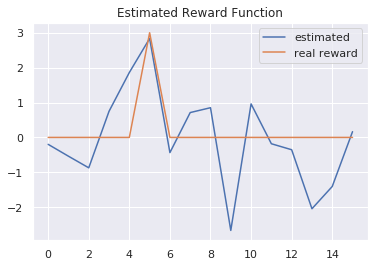

In [12]:
def evaluate(rmodel):
    plt.plot(rmodel.get_params(), label='estimated')
    plt.plot(env.reward_matrix, label='real reward')
    plt.legend()
    plt.title('Estimated Reward Function')

    _, topk_om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())

    print('Optimal state visitation frequencies for each grid cell:')
    print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

    print('Inferred ')
    print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))
    
evaluate(rmodel)

In [13]:
# Now can we get another feedback modality to work with the traditional grad descent? 

In [14]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(100)

step 0 loss -0.627
step 100 loss -0.342
step 200 loss -0.302
step 300 loss -0.272
step 400 loss -0.250
step 500 loss -0.233
step 600 loss -0.220
step 700 loss -0.209
step 800 loss -0.201
step 900 loss -0.195
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     6.2313 0.3629 0.    ]
 [0.     1.3977 0.008  0.    ]
 [0.     0.     0.     0.    ]]


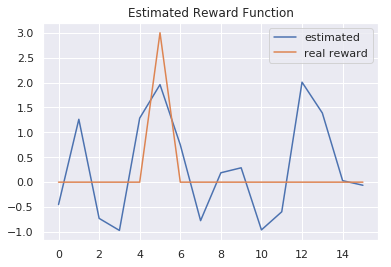

In [15]:
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(pc_feedback_model, comparison_dataset, rmodel, pc_bias_params, use_bias_prior=False)
evaluate(rmodel)

In [ ]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)
_, rmodel, _ = trad_optimize(irl_feedback_model, irl_dataset, rmodel, irl_bias_params, use_bias_prior=True)
evaluate(rmodel)

In [17]:
def multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=True): 
    
    lr = 1
    steps = 1000
    loss_prev = float('Inf')
    delta = 100
    step = 0
    
    while(step<steps):
    
        grew = jnp.zeros_like(env.reward_matrix)
        
        if optimize_reward: 
            for model, data, bias_params in zip(model_list, data_list, bias_list):
                grew += model.log_likelihood_grad_rew(data, rmodel, bias_params)

        new_r = rmodel.get_params() + lr*grew
        rmodel.set_params(new_r)
        
        for k, (model, data, bias_params, use_bias_prior) in enumerate(zip(model_list, data_list, bias_list, use_bias_list)):
            gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
            if use_bias_prior: 
                bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
                gbias = gbias + bias_prior_grad
        
            bias_list[k] = bias_params + lr*(gbias)
            
                    
            if use_bias_prior: 
                bias_list[k] = model.bias_prior.project_to_support(bias_list[k])


        for k, (model, data, bias_params) in enumerate(zip(model_list, data_list, bias_list)):
            loss = model.log_likelihood(data, rmodel, bias_params)
          
            if step % 100 == 0:
                print('step %d loss %.3f model %d' %(step, loss, k))
                print('---', bias_params)
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1
        
    return model_list, rmodel, bias_list

In [45]:
# Reinitializing all the models

def init_models(opt_reward=False):
    irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rng = jrandom.PRNGKey(42)
    rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
    irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
    # we'll do IRL based on 10 trajectories
    irl_dataset = irl_expert.interact(10)

    pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
    rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
    pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

    # generate some random trajectories & compare a random subset of them
    def generate_comparison_dataset(pc_ntraj):
        pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
        to_compare_first = np.arange(len(pc_trajectories['states']))
        comparisons = []
        for first_idx in range(pc_ntraj):
            second_idx = np.random.randint(pc_ntraj - 1)
            if second_idx >= first_idx:
                second_idx += 1
            traj1_is_better = pc_expert.interact(
                dict(states=pc_trajectories['states'][first_idx]),
                dict(states=pc_trajectories['states'][second_idx]))
            if traj1_is_better:
                # the better trajectory comes before the worse one
                comparisons.append((first_idx, second_idx))
            else:
                comparisons.append((second_idx, first_idx))
        return {
            'trajectories': pc_trajectories,
            'comparisons': np.asarray(comparisons),
        }

    comparison_dataset = generate_comparison_dataset(100)

    top_K_expert = experts.TopKExpert(env, temp=.4, K=.05, seed=42)
    def generate_topk_dataset(n_traj):
        # def genereate_top_K_dataset(n_traj): 
        import random
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        rmodel.set_params(env.reward_matrix)
        traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
        labels= top_K_expert.interact(traj, rmodel)

        labels_final, traj_final = [], []
        for l, t in zip(labels, traj['states']): 
            if not(l):
                if True:#random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                    labels_final.append(l), traj_final.append(t)
            else: 
                labels_final.append(l), traj_final.append(t)

        labels_final = np.array([int(l) for l in labels_final])

        return {
            'trajectories':np.array(traj_final), 
            'labels':labels_final
        }

    top_K_dataset = generate_topk_dataset(1000)

    import pref_bootstrap.feedback_learner_topk as fbl_topk
    top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)

    rmodel = r_models.LinearRewardModel(env.obs_dim)
    import jax
    import jax.numpy as jnp

    rng = jrandom.PRNGKey(23)
    rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

    model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model]
    data_list = [top_K_dataset, comparison_dataset, irl_dataset]
    bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params]
    use_bias_list = [False, True, False]
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    if opt_reward:
        rmodel.set_params(env.reward_matrix)
        
    names = ['top_K', 'paired_comparisons', 'blind_irl']
    
    biases_actual = []
    
    # TOP K biases 
    biases_actual.append((top_K_expert.temp, top_K_expert.cutoff))
    
    # pc actual bias
    biases_actual.append((pc_expert.boltz_temp))
    
    #blind irl actual bias
    biases_actual.append((irl_bias_params))
        
    return model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual

In [ ]:
model_list, data_list, rmodel, bias_list, use_bias_list, names, _ = init_models(opt_reward=True)
models, rmodel, biases = multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=False)

cutoff 18.0


/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [0.5868 7.5754]
step 0 loss -1.393 model 0
--- [-0.268   7.7468]
step 0 loss -0.693 model 1
--- 0.0
step 0 loss -8.202 model 2
--- [0.273  0.9186 0.8208 0.2088 0.2972 2.6928 0.5749 0.5896 0.7297 0.2303 0.3191 0.9805 0.0829 0.8147
 0.905  0.0139]


Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Inferred 
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 6.8535e+00 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 1.2728e-03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


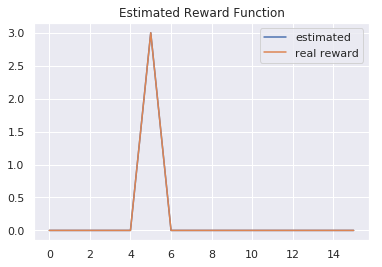

In [30]:
evaluate(rmodel)

Text(0.5,1,'Blind IRL')

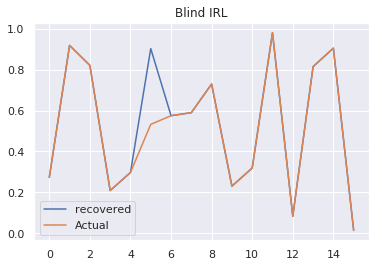

In [23]:
plt.plot(biases[-1], label="recovered")
plt.plot(irl_bias_params, label='Actual')
plt.legend()
plt.title('Blind IRL')

In [24]:
# Plot the distribution of rewards and labels: 
def topK_dist(top_K_dataset): 
    states = top_K_dataset['trajectories']
    flat_states = states.flatten()
    all_fn_values = rmodel.get_params() #(self.env.observation_matrix)
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return per_traj_rew_est

In [25]:
# Todo: method comparison:  

# mean reward, etc. 

# Todo: Bias parameter recovery w each method

# Todo: reward recovery. 

# Todo: Data efficiency of each algo

In [26]:
# Plot 1. Method comparison. 

model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model]
data_list = [top_K_dataset, comparison_dataset, irl_dataset]
bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params]
use_bias_list = [False, True, False]
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)

In [39]:
import pandas as pd

def get_rew(trajs, rmodel): 
    states = trajs['states']
    flat_states = states.flatten()
    all_fn_values = rmodel
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return np.mean(per_traj_rew_est)

def evaluate_full(rmodel): 
    _, om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())
    trajs = mce_irl.mce_irl_sample(env, 100, R=rmodel.get_params())
    rews = get_rew(trajs, rmodel.get_params())
    
    return rmodel.get_params(), rews, trajs

In [32]:
biases_recovered, biases_actual, recovered_reward, mean_reward, obs_obtained, method, fold = [],[],[],[],[],[], []

for _ in range(10): 
    
    # eval each method
        # reset reward_model
        
    model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual = init_models()
    for model, dataset, bias, ub, name, b_actual in zip(model_list, datalist, rmodel, bias_list, use_bias_list, name, biases_actual):     
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        _, rmodel, bias_p_recovered = trad_optimize(model, dataset, rmodel, bias_params, use_bias_prior=ub)
        
        recovered_reward, mean_reward, obs_f = evaluate_full(rmodel)
        
        biases_recovered.append(bias_p_recovered)
        biases_actual.append(biases_actual)
        recovered_reward.append(recovered_reward)
        mean_reward_obtained.append(mean_reward)
        obs_obtained.append(obs_f)
        method.append(name)
        fold.append(_)
        
        
optimal_obs = []
obs_optimal = [optimal_obs]*len(method)
optimal_rew = [optimal_rew]*len(method)
        
res = pd.DataFrame({
    'bias_actual':biases_actual, 
    'biases_recoverd':biases_recovered, 
    'recovered_reward':recovered_reward,
    'mean_reward_obtained':mean_reward,
    'obs_obtained':obs_obtained,
    'obs_optimal':obs_optimal, 
    'optimal_rew':optimal_rew
})
        

SyntaxError: invalid syntax (<ipython-input-32-879260d872b3>, line 27)